# MESA session 2: solution notebook


In [3]:
import numpy as np
import mesa_reader as mr
import matplotlib.pyplot as plt 
import astropy.units as u
import astropy.constants as const

# 2 Evolution of massive stars with mass loss

In [62]:
# Read in the new data for our higher mass star with mass loss
M50_DSF1_hist_data = mr.MesaData('data/M50_overshoot0_DSF1p0/LOGS/history.data')
M50_DSF05_hist_data = mr.MesaData('data/M50_overshoot0_DSF0p5/LOGS/history.data')
M50_DSF01_hist_data = mr.MesaData('data/M50_overshoot0_DSF0p1/LOGS/history.data')

print(M50_DSF1_hist_data.bulk_names)

('model_number', 'num_zones', 'star_age', 'log_dt', 'star_mass', 'log_xmstar', 'log_abs_mdot', 'mass_conv_core', 'conv_mx1_top', 'conv_mx1_bot', 'conv_mx2_top', 'conv_mx2_bot', 'mx1_top', 'mx1_bot', 'mx2_top', 'mx2_bot', 'mix_type_1', 'mix_qtop_1', 'mix_type_2', 'mix_qtop_2', 'mix_type_3', 'mix_qtop_3', 'mix_type_4', 'mix_qtop_4', 'mix_type_5', 'mix_qtop_5', 'mix_type_6', 'mix_qtop_6', 'mix_type_7', 'mix_qtop_7', 'mix_type_8', 'mix_qtop_8', 'mix_type_9', 'mix_qtop_9', 'mix_type_10', 'mix_qtop_10', 'log_LH', 'log_LHe', 'log_LZ', 'log_Lnuc', 'pp', 'cno', 'tri_alfa', 'epsnuc_M_1', 'epsnuc_M_2', 'epsnuc_M_3', 'epsnuc_M_4', 'epsnuc_M_5', 'epsnuc_M_6', 'epsnuc_M_7', 'epsnuc_M_8', 'burn_type_1', 'burn_qtop_1', 'burn_type_2', 'burn_qtop_2', 'burn_type_3', 'burn_qtop_3', 'burn_type_4', 'burn_qtop_4', 'burn_type_5', 'burn_qtop_5', 'burn_type_6', 'burn_qtop_6', 'burn_type_7', 'burn_qtop_7', 'burn_type_8', 'burn_qtop_8', 'burn_type_9', 'burn_qtop_9', 'burn_type_10', 'burn_qtop_10', 'he_core_mass',

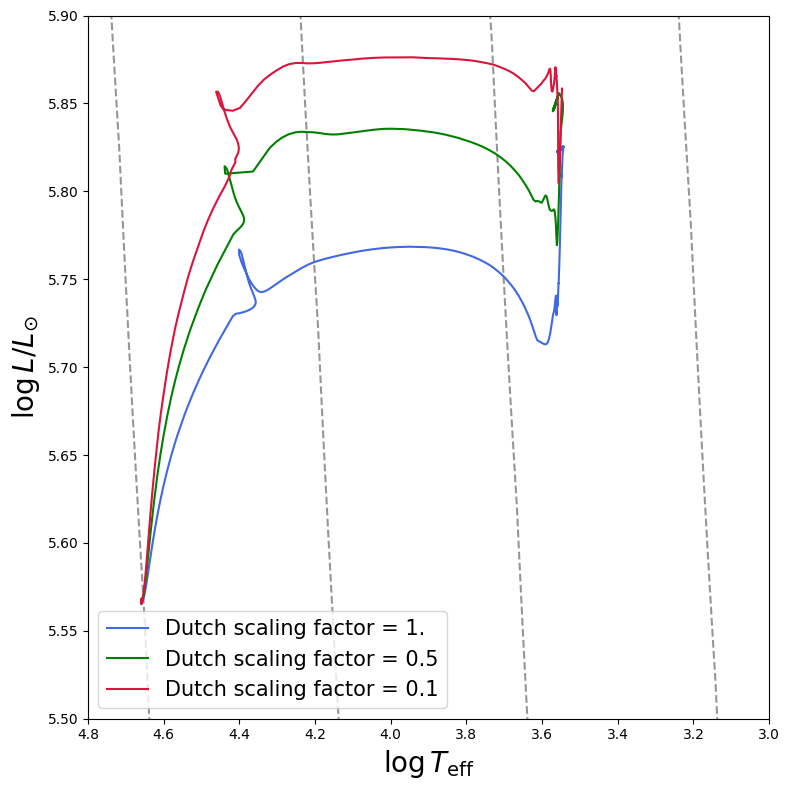

In [63]:
plot_HR_with_radius_contours(list_of_hist_data = [M50_DSF1_hist_data, M50_DSF05_hist_data, M50_DSF01_hist_data],
                            label_list = ['Dutch scaling factor = 1.', 'Dutch scaling factor = 0.5', 'Dutch scaling factor = 0.1'],
                            save_path='plots/M50_HR_diagram_winds.png',
                            xlim=(4.8, 3), ylim=(5.5, 5.9)
                            )



### Helium abundance versus stellar age

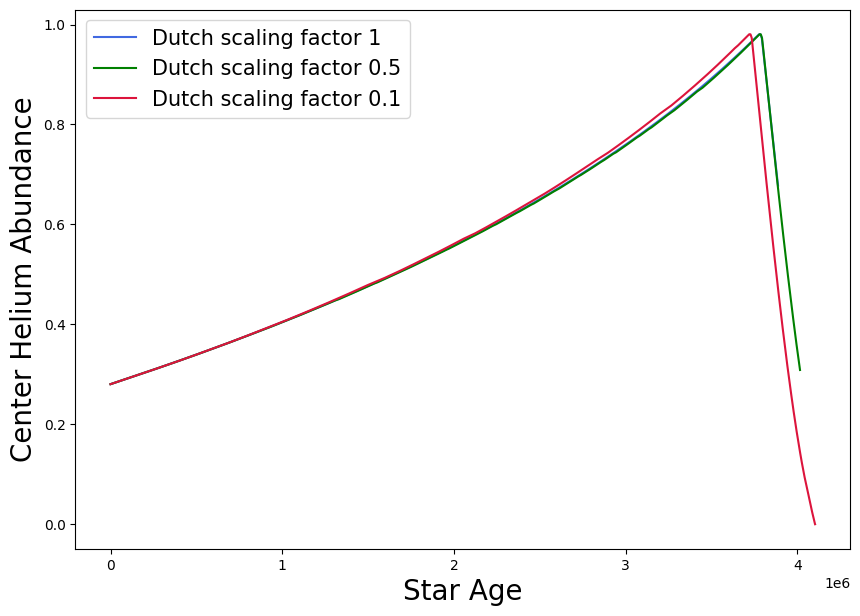

In [64]:
fig, ax = plt.subplots(figsize = (10,7))

##########
# Select the data to plot
for histdata, label, colors in zip([M50_DSF1_hist_data, M50_DSF05_hist_data, M50_DSF01_hist_data],
                                 ['Dutch scaling factor 1', 'Dutch scaling factor 0.5', 'Dutch scaling factor 0.1'],
                                 ['royalblue', 'green', 'crimson']):
    plt.plot(histdata.star_age, histdata.center_he4, label = label, color = colors)

# 'log_center_T', 'log_center_Rho',
plt.legend(fontsize = 15)
plt.xlabel("Star Age", fontsize = 20 )
plt.ylabel("Center Helium Abundance", fontsize = 20 )
plt.savefig('plots/M50_central_He.png', bbox_inches = 'tight')
plt.show()

Core properties didn't change much when changing the winds (which is an external thing!)

### Plot surface abundances

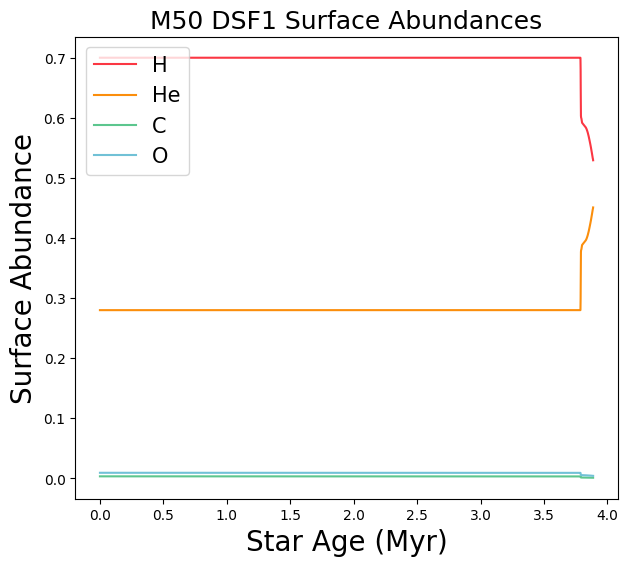

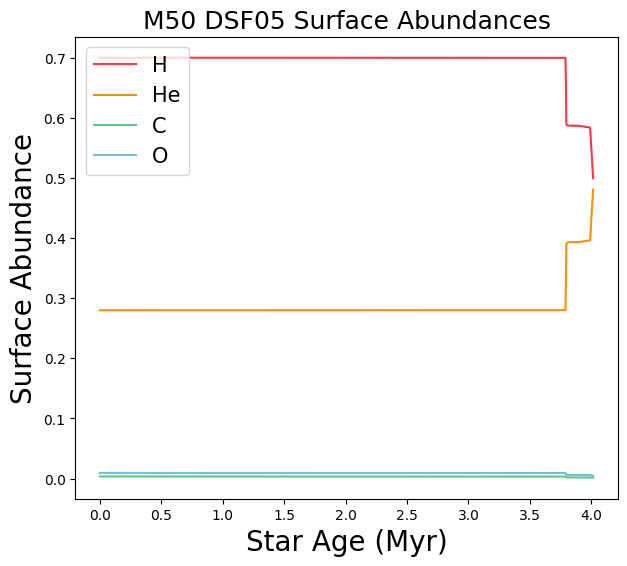

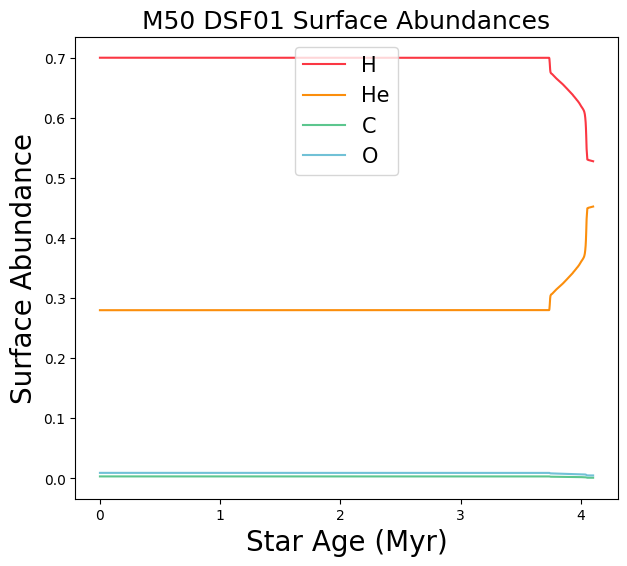

In [65]:
def plot_surface_abundances(histdata, var_name = 'DSF05'):
    fig, ax = plt.subplots(figsize = (7,6))

    ##########
    # Select the data to plot
    plt.plot(histdata.star_age*1e-6, histdata.surface_h1, label = 'H', color = '#FB3743')
    plt.plot(histdata.star_age*1e-6, histdata.surface_he4, label = 'He', color = '#FB8E0C')
    plt.plot(histdata.star_age*1e-6, histdata.surface_c12, label = 'C', color = '#5CC68E')
    plt.plot(histdata.star_age*1e-6, histdata.surface_o16, label = 'O', color = '#71C1D6')

    plt.title(f"M50 {var_name} Surface Abundances", fontsize = 18)
    plt.legend(fontsize = 15)
    plt.xlabel("Star Age (Myr)", fontsize = 20 )
    plt.ylabel("Surface Abundance", fontsize = 20 )
    plt.savefig(f'plots/M50_{var_name}_surface_abundances.png', bbox_inches = 'tight')
    plt.show()

plot_surface_abundances(M50_DSF1_hist_data, var_name='DSF1')
plot_surface_abundances(M50_DSF05_hist_data, var_name='DSF05')
plot_surface_abundances(M50_DSF01_hist_data, var_name='DSF01')



Surface abundances change much more when you change the winds! I.e. with stronger winds, the stars become less H rich and more He rich in their envelope. 

### Extra: abundance profile beyond core He exhaust:

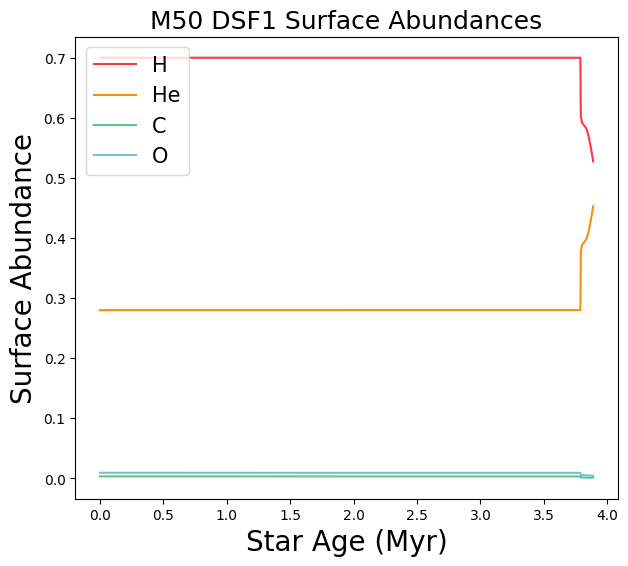

In [66]:
# Re-read in to load the newest data
M50_DSF1_hist_data = mr.MesaData('data/M50_overshoot0_DSF1p0/LOGS/history.data')

# Plot it
plot_surface_abundances(M50_DSF1_hist_data, var_name='DSF1')
